In [1]:
import os
from zipfile import ZipFile
import requests
import glob as glob

import warnings
import logging
import absl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import cv2 as cv

import tensorflow as tf
import tensorflow_hub as hub

warnings.filterwarnings("ignore", module='absl')

#Capture all errors in the log system.
logging.captureWarnings(True)

#Set the absl logger level to `error`
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Download sample CamVid images.

In [2]:
def download_images(url, save_path):
    url = url
    file = requests.get(url)
    
    open(save_path, 'wb').write(file.content)

def unzip(zipped=None):
    try:
        with ZipFile(zipped) as z:
            z.extractall('./')
            print("Done extracting files.")
    except Exception as e:
        print("\nInvalid file", e)

In [3]:
URL = r"https://www.dropbox.com/s/wad5js22fbeo1be/camvid_images.zip?dl=1"
save_path = "camvid_images.zip"

download_images(URL, save_path)
unzip(zipped="camvid_images.zip")

os.remove(save_path)

Done extracting files.


- Display some of the images.

In [4]:
image_paths = sorted(glob.glob("camvid_images/*.png"))

for img in range(len(image_paths)):
    print(image_paths[img])

camvid_images/camvid_sample_1.png
camvid_images/camvid_sample_2.png
camvid_images/camvid_sample_3.png
camvid_images/camvid_sample_4.png


In [5]:
def load_image(path):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    #Add a batch dimension which is required by the model.
    image = np.expand_dims(img, axis=0) / 255.0
    
    return image

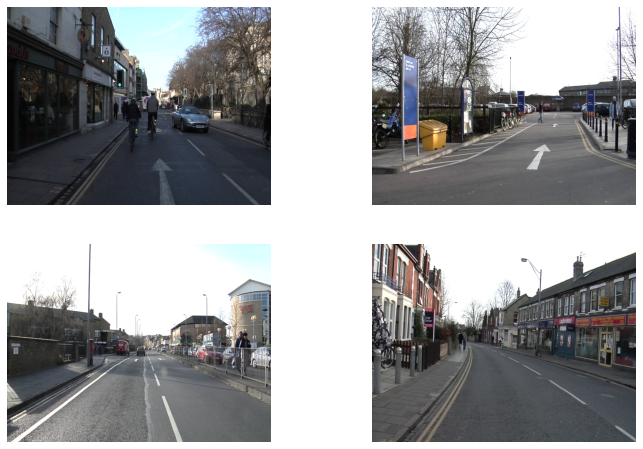

In [6]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, axis in enumerate(ax.flat):
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis('off')

- A dictionary to map class ids to class names and class colors.

In [7]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Archway'],
         2: [(0, 128, 192),  'Bicyclist'],
         3: [(0, 128, 64),   'Bridge'],
         4: [(128, 0, 0),    'Building'],
         5: [(64, 0, 128),   'Car'],
         6: [(64, 0, 192),   'Cart/Luggage/Pram'],
         7: [(192, 128, 64), 'Child'],
         8: [(192, 192, 128),'Column Pole'],
         9: [(64, 64, 128),  'Fence'],
        10: [(128, 0, 192),  'LaneMkgs Driv'],
        11: [(192, 0, 64),   'LaneMkgs NonDriv'],
        12: [(128, 128, 64), 'Misc Text'],
        13: [(192, 0, 192),  'Motorcycle/Scooter'],
        14: [(128, 64, 64),  'Other Moving'],
        15: [(64, 192, 128), 'Parking Block'],
        16: [(64, 64, 0),    'Pedestrian'],
        17: [(128, 64, 128), 'Road'],
        18: [(128, 128, 192),'Road Shoulder'],
        19: [(0, 0, 192),    'Sidewalk'],
        20: [(192, 128, 128),'Sign Symbol'],
        21: [(128, 128, 128),'Sky'],
        22: [(64, 128, 192), 'SUV/Pickup/Truck'],
        23: [(0, 0, 64),     'Traffic Cone'],
        24: [(0, 64, 64),    'Traffic Light'],
        25: [(192, 64, 128), 'Train'],
        26: [(128, 128, 0),  'Tree'],
        27: [(192, 128, 192),'Truck/Bus'],
        28: [(64, 0, 64),    'Tunnel'],
        29: [(192, 192, 0),  'Vegetation Misc'],
        30: [(0, 0, 0),      'Void'],
        31: [(64, 192, 0),   'Wall']  
    }

### Model inference using TensorFlow Hub

In [ ]:
model_url = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1"
print(f"Loading model {model_url}...", end="")

seg_model = hub.load(model_url)
print("\nDone!")

### Model inferences.
1. model.predict()

In [25]:
pred_mask = seg_model.predict(images[0]) #Use first image in the list to make prediction.

#The mask has the shape of (B, H, W, C)
print(f"Shape of the predicted mask: {pred_mask.shape}")

Shape of the predicted mask: (1, 720, 960, 33)


2. Post-process the Predicted Segmentation Mask.

In [26]:
#Convert tensor to numpy array.
pred_mask = pred_mask.numpy()

#The first class is the background which is added by the model, but you can remove it.
pred_mask = pred_mask[:, :, :, 1:]

#Remove the batch dimension.
pred_mask = np.squeeze(pred_mask)

#Just for the confirmation purposes.
print("The new shape of the prediction mask: ", pred_mask.shape)

The new shape of the prediction mask:  (720, 960, 32)


- Visualize the intermediate results.

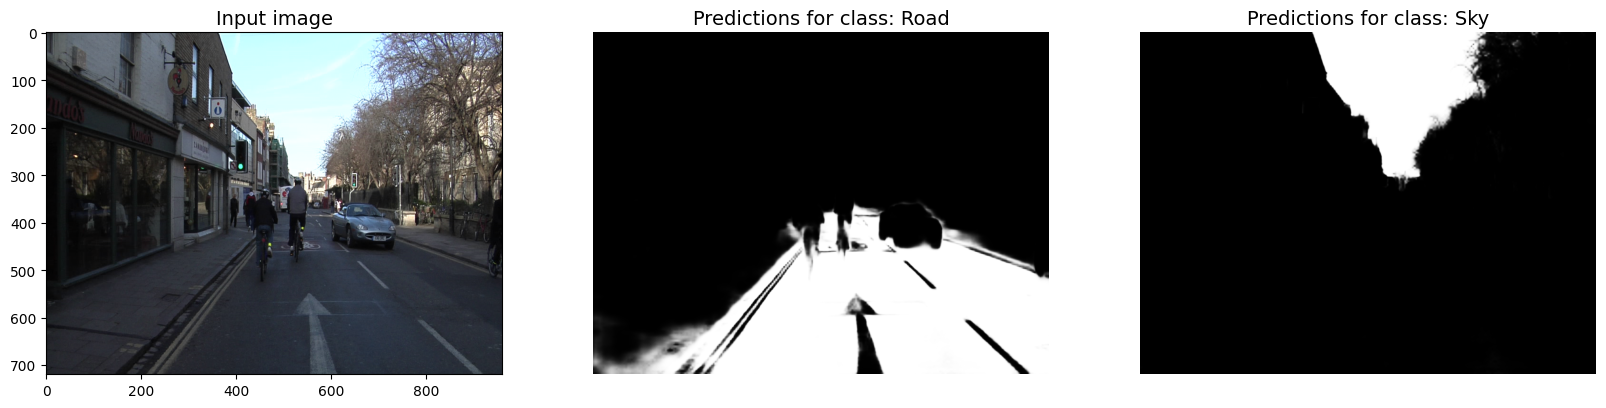

In [27]:
plt.figure(figsize=(20, 8))

plt.subplot(131);plt.title("Input image", fontsize=14);plt.imshow(np.squeeze(images[0]))
plt.subplot(132);plt.title("Predictions for class: Road", fontsize=14);plt.imshow(pred_mask[:,:,17], cmap='gray');plt.axis('off');
plt.subplot(133);plt.title("Predictions for class: Sky", fontsize=14);plt.imshow(pred_mask[:, :, 21], cmap='gray');plt.axis('off');

- Assign each pixel a class label.

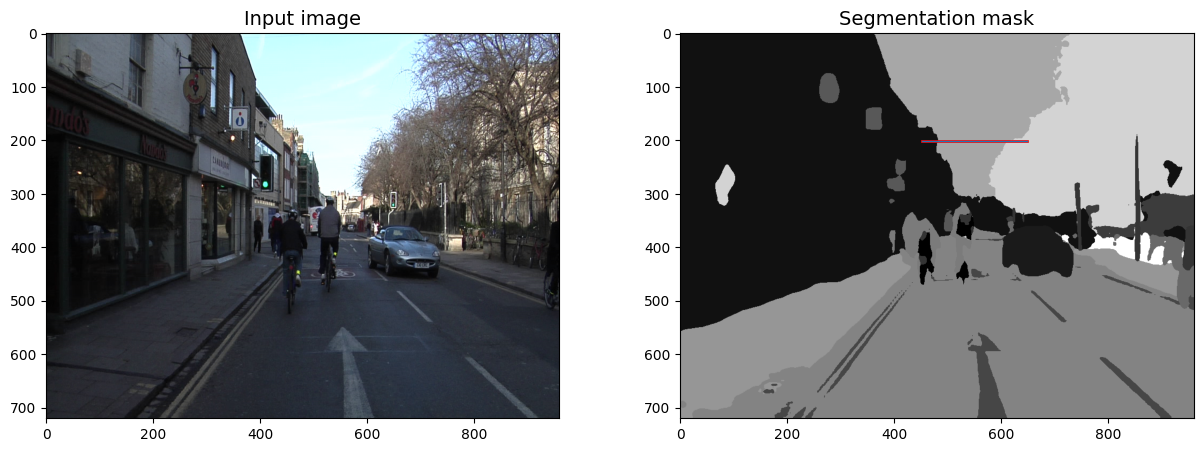

In [35]:
pred_mask_label = np.argmax(pred_mask, axis=-1)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.title("Input image", fontsize=14)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1,2,2)
plt.title("Segmentation mask", fontsize=14)
plt.imshow(pred_mask_label, cmap='gray')
plt.gca().add_patch(Rectangle((450, 200), 200, 3, edgecolor='red', facecolor=None, linewidth=.5));

- Convert single channel mask to RGB

In [36]:
def class_to_rgb(mask_class, class_index):
    #Create RGB Channels.
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)
    
    #Populate the colors.
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]
        
    seg_rgb_map = np.stack([r_map, g_map, b_map], axis=2)
    
    return seg_rgb_map

(-0.5, 959.5, 719.5, -0.5)

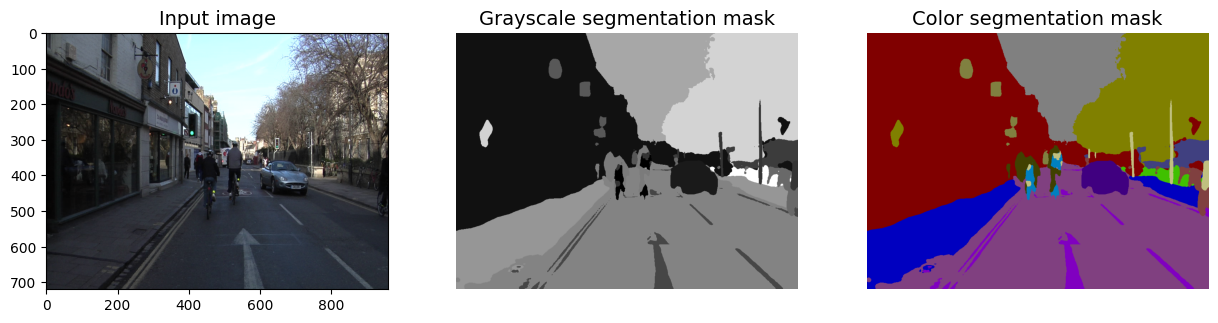

In [39]:
#Convert the grayscale segmentation mask to a color segmentation mask.
pred_mask_rgb = class_to_rgb(pred_mask_label, class_index)

plt.figure(figsize=(15, 8))

plt.subplot(131);plt.title("Input image", fontsize=14);plt.imshow(np.squeeze(images[0]));lt.axis('off');
plt.subplot(132);plt.title("Grayscale segmentation mask", fontsize=14);plt.imshow(pred_mask_label, cmap='gray');plt.axis('off');
plt.subplot(133);plt.title("Color segmentation mask", fontsize=14);plt.imshow(pred_mask_rgb);plt.axis('off')

### Formalize the implementation.
1. Image_overlay()

In [60]:
#Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, seg_map_rgb):
    alpha = 1.0 #Transparency for the original image.
    beta  = 0.6 #Transparency for the segmentation map.
    gamma = 0.0 #Scalar added to each sum.
    
    image = (image * 255.0).astype(np.uint8)
    seg_map_rgb = cv.cvtColor(seg_map_rgb, cv.COLOR_RGB2BGR)
    
    image = cv.addWeighted(image, alpha, seg_map_rgb, beta, gamma)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    return image

2. run_inference()

In [61]:
def run_inference(images, model):
    for img in images:
        #Forward pass through  and convert to numpy array from tensor.
        pred_mask = model.predict(img).numpy()
        
        #Remove the background class added by the model.
        pred_mask = pred_mask[:, :, :, 1:]
        
        #Remove the batch dimension.
        pred_mask = np.squeeze(pred_mask)
        
        pred_mask_class = np.argmax(pred_mask, axis=-1)
        
        #Conver the mask to color.
        pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)
        
        plt.figure(figsize=(20, 8))
        
        plt.subplot(131);plt.title("Input image");plt.imshow(img[0]);plt.axis('off');
        plt.subplot(132);plt.title("Predicted mask");plt.imshow(pred_mask_rgb);plt.axis('off');
        plt.subplot(133);plt.title("Overlayed image");plt.imshow(image_overlay(img[0], pred_mask_rgb));plt.axis('off');
        plt.show()

3. plot_color_legend()

In [62]:
def plot_color_legend(class_index):
    #Extract colors and class names from the class index.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [lab[1] for lab in class_index.values()]
    
    fig, ax = plt.subplots(nrows=2, ncols=16, figsize=(20, 3))
    plt.subplots_adjust(wspace=0.5, hspace=0.01)
    
    #display color legend.
    for i, axis in enumerate(ax.flat):
        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize=8)
        axis.axis('off')

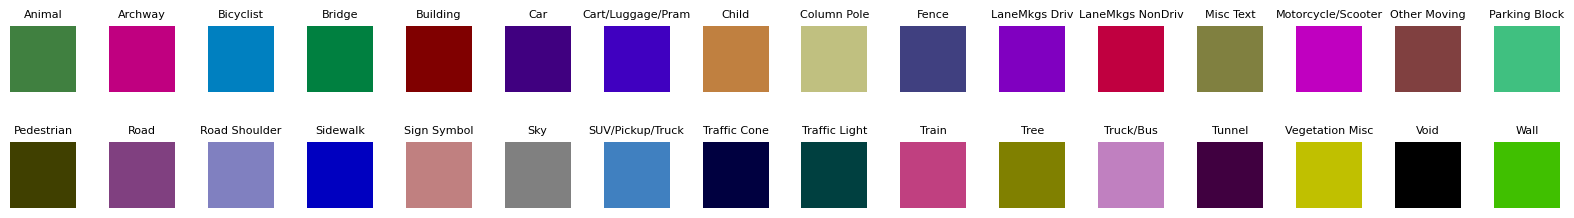

In [63]:
plot_color_legend(class_index)

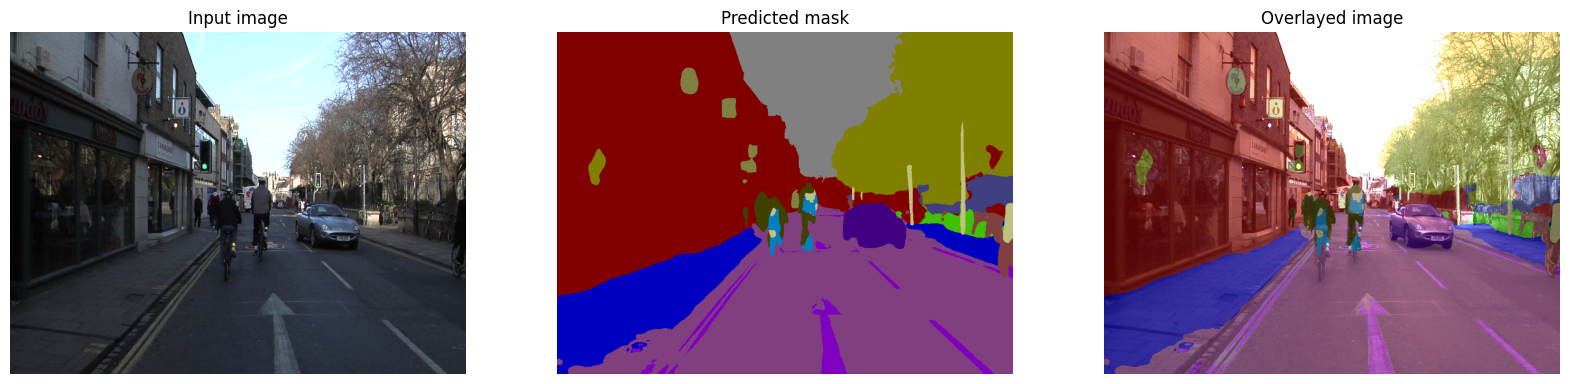

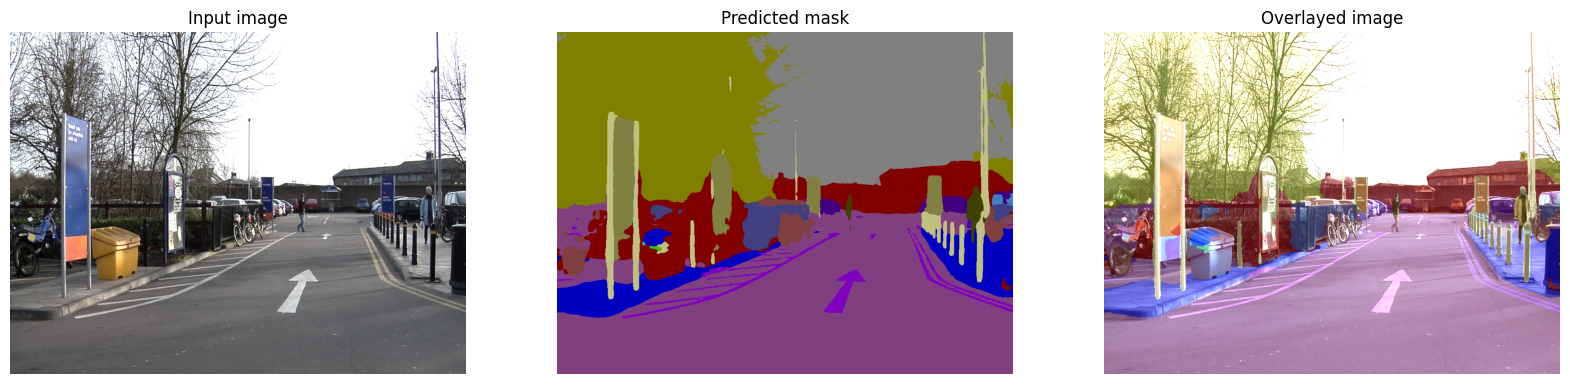

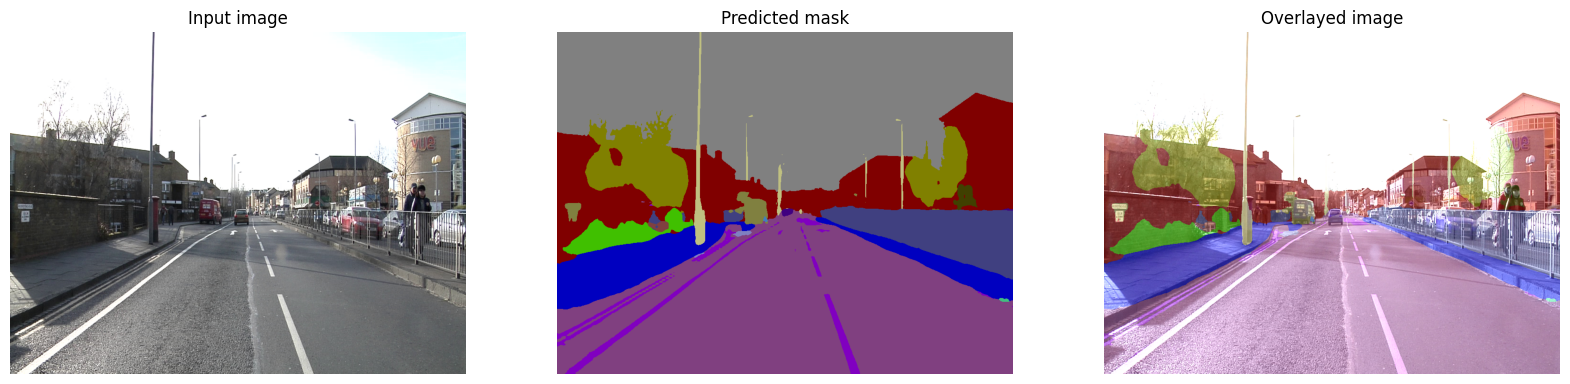

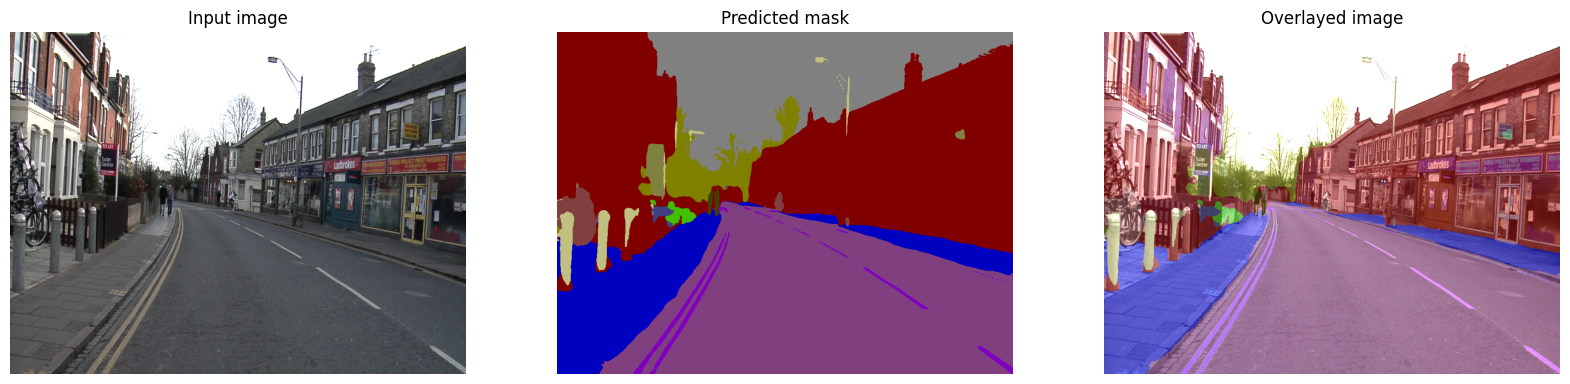

In [64]:
run_inference(images, seg_model)